In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import r2_score, f1_score, accuracy_score

from catboost import CatBoostClassifier, Pool, metrics as catmetrics, cv

In [2]:
df_X = pd.read_csv('train/train_meta.csv', index_col=0)
df_y = pd.read_csv('train/train_gts.csv', index_col=0)

#print(df_train[df_train["validated_by_human"] & df_train["initial_autogenerated_report"]].shape)
#null_value_stats = df_train.isnull().sum(axis=0)
#null_value_stats[null_value_stats != 0]

In [3]:
df = pd.merge(df_X, df_y, on='record_name', how='outer')
print(dict(df.dtypes))
df.head(4)

{'patient_id': dtype('float64'), 'age': dtype('float64'), 'sex': dtype('int64'), 'height': dtype('float64'), 'weight': dtype('float64'), 'nurse': dtype('float64'), 'site': dtype('float64'), 'device': dtype('O'), 'recording_date': dtype('O'), 'report': dtype('O'), 'scp_codes': dtype('O'), 'heart_axis': dtype('O'), 'infarction_stadium1': dtype('O'), 'infarction_stadium2': dtype('O'), 'validated_by': dtype('float64'), 'second_opinion': dtype('bool'), 'initial_autogenerated_report': dtype('bool'), 'validated_by_human': dtype('bool'), 'baseline_drift': dtype('O'), 'static_noise': dtype('O'), 'burst_noise': dtype('O'), 'electrodes_problems': dtype('O'), 'extra_beats': dtype('O'), 'pacemaker': dtype('O'), 'strat_fold': dtype('int64'), 'filename_lr': dtype('O'), 'filename_hr': dtype('O'), 'record_name': dtype('O'), 'group': dtype('int64'), 'myocard': dtype('int64')}


,patient_id,age,sex,height,weight,nurse,site,device,recording_date,report,...,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr,record_name,group,myocard
0,18792.0,55.0,0,NaN,70.0,2.0,0.0,CS-12 E,1984-12-08 09:44:43,sinusrhythmus normales ekg,...,NaN,NaN,NaN,NaN,10,records100/00000/00009_lr,records500/00000/00009_hr,00009_hr,1,0
1,13619.0,56.0,0,NaN,NaN,2.0,0.0,CS-12 E,1985-02-10 12:04:03,"erneut vorhofflattern unter 3x1 cordichin ,1x0...",...,NaN,NaN,NaN,NaN,9,records100/00000/00034_lr,records500/00000/00034_hr,00034_hr,3,0
2,11315.0,25.0,1,NaN,63.0,2.0,0.0,CS-12 E,1985-03-14 09:38:53,sinusrhythmus normales ekg,...,NaN,NaN,NaN,NaN,8,records100/00000/00043_lr,records500/00000/00043_hr,00043_hr,3,0
3,18153.0,35.0,0,NaN,82.0,2.0,0.0,CS-12 E,1985-05-18 08:15:54,sinusrhythmus unvollstÄndiger rechtsschenkelbl...,...,NaN,NaN,NaN,NaN,1,records100/00000/00052_lr,records500/00000/00052_hr,00052_hr,2,0


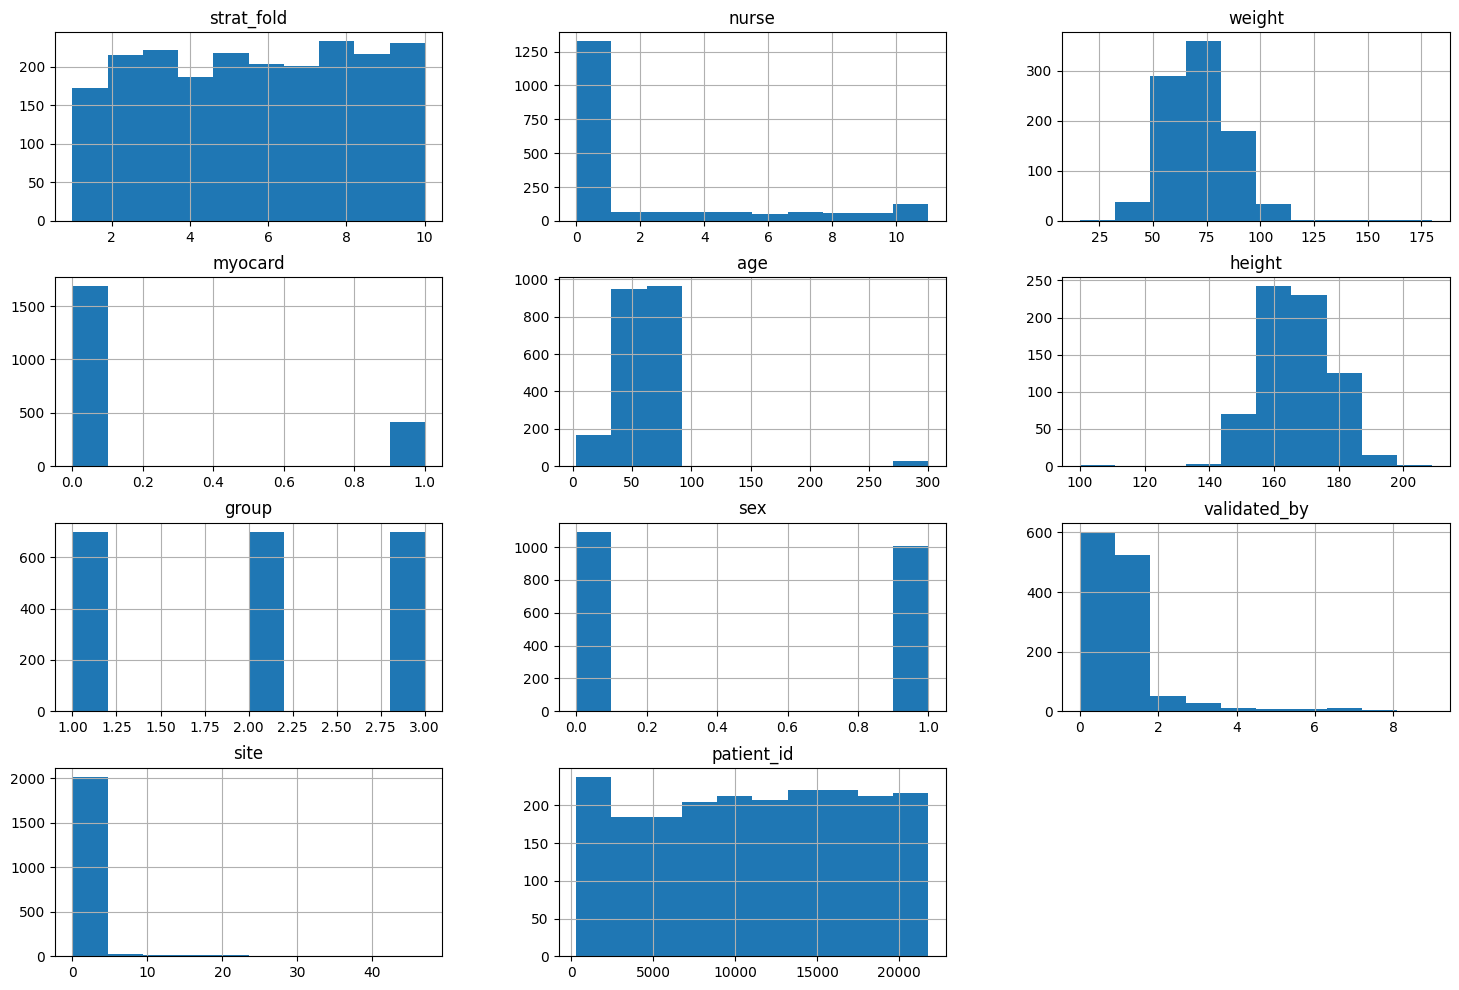

In [4]:
features = list(set(df.columns) - set(['DateTime']))

_ = df[features].hist(figsize=(18,12))

In [5]:
# Убираем пустые столбцы, создаём их список
sum_series = df.isna().sum(axis=0)
dropped = list(sum_series[sum_series > 1900].keys())
df.drop(dropped, axis=1, inplace=True)

In [6]:
sum_series = df.isna().sum(axis=0)
print(sum_series[sum_series != 0])
sum_series[sum_series != 0].keys()

height                 1412
weight                 1196
nurse                   154
site                      1
heart_axis              870
infarction_stadium1    1593
validated_by            859
static_noise           1791
dtype: int64


Index(['height', 'weight', 'nurse', 'site', 'heart_axis',
       'infarction_stadium1', 'validated_by', 'static_noise'],
      dtype='object')

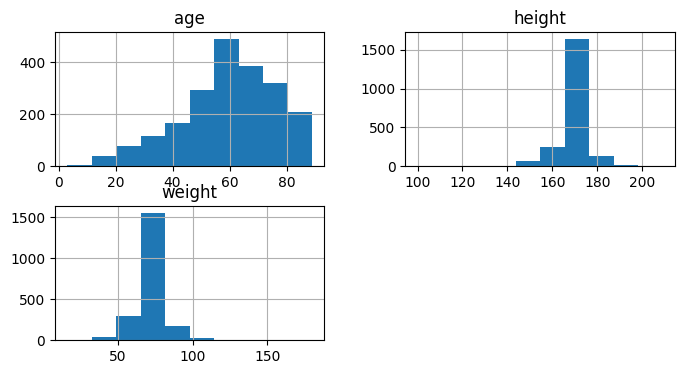

In [7]:
def fillmean(*col_names):
    for col in col_names:
        if (df.dtypes[col] != float):
            raise Exception(f"Type of column `{col}` is not float")
        else:
            df[col].fillna(df[df[col].notna()][col].mean(), inplace=True)
    df[list(col_names)].hist(figsize=(8,4))

df.loc[df["age"]>100, ["age"]] = np.nan
fillmean( "age", "height","weight") # nurse, site, validated_by, heart_axis... – категориальные

df.replace("unknown", "-1", inplace=True)
for col in sum_series[sum_series != 0].keys(): # crINGE
    nonevalue = np.array(-1).astype(df.dtypes[col])
    df[col].fillna(nonevalue, inplace=True)

In [8]:
imd = []
for fn in df['record_name']:
    with open(f"train/{fn}.npy", "rb") as f:
        data = np.load(f, allow_pickle=True)
        imd.append([fn, data])
signals = pd.DataFrame(imd, columns=["record_name","signal"])
signals.head()

,record_name,signal
0,00009_hr,"[[-0.12, -0.12, -0.12, -0.12, -0.121, -0.12, -..."
1,00034_hr,"[[0.935, 0.935, 0.936, 0.932, 0.941, 0.935, 0...."
2,00043_hr,"[[-0.005, -0.005, -0.005, -0.005, -0.004, -0.0..."
3,00052_hr,"[[-0.025, -0.025, -0.025, -0.025, -0.025, -0.0..."
4,00057_hr,"[[-0.155, -0.155, -0.155, -0.156, -0.153, -0.1..."


In [9]:
signals.isna().sum()

record_name    0
signal         0
dtype: int64

In [10]:
# with open("tt.txt", mode="w") as f:
#     ll = signals.iloc[0,1].astype(list)
#     for l in ll:
#         f.write(str(list(l))+"\n")

In [11]:
# person=4
# ll = images.iloc[person].astype(list)
# myoc = labels.iloc[person]
# for i in range(len(ll)):
#     plt.figure(figsize=(40, 8))
#     plt.title(f'ECG {person}-{i}')
#     plt.plot(list(ll[i]), 'go', linewidth=1, markersize=1, linestyle='-',
#             label='ECG')
#     plt.plot([0]*len(ll[i]), 'r', linewidth=2, markersize=0, linestyle='-',
#             label='ECG')
#     plt.grid(visible=True, which='both', axis='both')

#     plt.xlabel('t')
#     plt.ylabel('v')
#     plt.legend()
#     plt.show();
# print(myoc)

In [12]:
all_im = pd.merge(df, signals, on='record_name', how='outer')
images = all_im["signal"]
labels = all_im["myocard"]

In [13]:
# from tensorflow.keras import Sequential
# from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# # Variables
# INPUT_SHAPE = (12, 5000, 1)
# FILTER1_COUNT = 16
# FILTER2_COUNT = 32
# FILTER3_COUNT = 128
# FILTER1_SHAPE = (1, 50)
# FILTER2_SHAPE = (1, 10)
# STRIDE_SHAPE = (1, 5)
# POOL_SHAPE = (1, 2)
# FULLY_CONNECT_NUM = 32
# NUM_CLASSES = 1

# # Model architecture implementation
# model = Sequential()
# model.add(Conv2D(FILTER1_COUNT, FILTER1_SHAPE, strides=STRIDE_SHAPE, activation='relu', input_shape=INPUT_SHAPE))
# model.add(Conv2D(FILTER2_COUNT, FILTER2_SHAPE, activation='relu'))
# model.add(Flatten())
# model.add(Dense(FULLY_CONNECT_NUM, activation='relu'))
# model.add(Dense(NUM_CLASSES, activation='sigmoid')) # model.add(Dense(1, activation='sigmoid'))
# # # https://www.datacamp.com/tutorial/cnn-tensorflow-python#:~:text=of%20trainable%20parameters.-,Model%20training,-All%20the%20resources

In [14]:
# import tensorflow as tf
# train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.33, random_state=50)
# train_images, test_images, train_labels, test_labels = tf.convert_to_tensor(list(train_images)), tf.convert_to_tensor(list(test_images)),\
# tf.convert_to_tensor(train_labels), tf.convert_to_tensor(test_labels)
# # !!! 

In [15]:
# from tensorflow.keras.metrics import Precision, Recall

# BATCH_SIZE = 70
# EPOCHS = 50

# METRICS = metrics=['accuracy',
#                	Precision(name='precision'),
#                	Recall(name='recall')]

# model.compile(optimizer='adagrad',
#           	loss='binary_crossentropy',
#           	metrics = METRICS)

# # Train the model
# training_history = model.fit(train_images, train_labels,
#                 	epochs=EPOCHS, batch_size=BATCH_SIZE,
#                 	validation_data=(test_images, test_labels))

In [16]:
# print(f1_score(test_labels, np.array(model.predict(test_images) > 0.5), average = 'macro'))
# print(f1_score(test_labels, np.array(model.predict(test_images) > 0.5)))

In [17]:
# training_history = model.fit(train_images, train_labels,
#                 	epochs=15, batch_size=BATCH_SIZE,
#                 	validation_data=(test_images, test_labels))

In [18]:
#model.save('second_cv_model.ckpt')

In [20]:
import tensorflow as tf
model = tf.keras.models.load_model("second_cv_model.ckpt")

UnicodeDecodeError: 'utf-8' codec can't decode byte 0xce in position 66: invalid continuation byte

In [ ]:
# model.save('first_cv_model.ckpt')
# nm = tf.keras.models.load_model('first_cv_model.ckpt')
# h=nm.fit(train_images, train_labels,
#                 	epochs=1, batch_size=BATCH_SIZE,
#                 	validation_data=(test_images, test_labels))

In [ ]:
# def show_performance_curve(training_result, metric, metric_label):
    
# 	train_perf = training_result.history[str(metric)]
# 	validation_perf = training_result.history['val_'+str(metric)]
# 	intersection_idx = np.argwhere(np.isclose(train_perf,
#                                             	validation_perf, atol=1e-2)).flatten()[0]
# 	intersection_value = train_perf[intersection_idx]
    
# 	plt.plot(train_perf, label=metric_label)
# 	plt.plot(validation_perf, label = 'val_'+str(metric))
# 	plt.axvline(x=intersection_idx, color='r', linestyle='--', label='Intersection')
    
# 	plt.annotate(f'Optimal Value: {intersection_value:.4f}',
#          	xy=(intersection_idx, intersection_value),
#          	xycoords='data',
#          	fontsize=10,
#          	color='green')
            	 
# 	plt.xlabel('Epoch')
# 	plt.ylabel(metric_label)
# 	plt.legend(loc='lower right')
# show_performance_curve(training_history, 'recall', 'recall')

In [ ]:
'''plt.rcParams['figure.figsize']=(10,10)

corr = dtn.corr()
g = sns.heatmap(corr, square = True, annot=True)'''
None

In [ ]:

#dtn["device"].isin([511]).any()
#dtn.drop(labels = [444],axis = 0)
#dtn.drop(labels = [511],axis = 0)


In [ ]:
dtn = df.iloc[:,:-1]
ans = df.iloc[:,-1:]
#ans.head()

In [21]:
predicted_cv = model.predict(tf.convert_to_tensor(list(images)))>0.5
predicted_cv_df = pd.DataFrame((signals["record_name"], predicted_cv.reshape((predicted_cv.shape[0],)))).transpose()
predicted_cv_df.rename(columns={"Unnamed 0":"pred"}, inplace=True)

dtn = pd.merge(dtn, predicted_cv_df, on='record_name', how='outer')

NameError: name 'model' is not defined

In [ ]:
X = dtn.drop(["validated_by","initial_autogenerated_report", "filename_lr", "filename_hr", "record_name", "patient_id", "recording_date", "report"], axis = 1)
X["second_opinion"] = X['second_opinion'].astype(int)
#X["initial_autogenerated_report"] = X['initial_autogenerated_report'].astype(int)
X["validated_by_human"] = X['validated_by_human'].astype(int)
X["BMI"] = X["weight"]*1e04 / (X["height"]).apply(np.square)
X["pred"] = X["pred"].astype(int)

cat_vars=['device', "scp_codes", 'heart_axis', 'infarction_stadium1', 'infarction_stadium2', 'baseline_drift', 'static_noise', 'burst_noise', 'electrodes_problems', 'extra_beats', 'pacemaker']  
print(dict(X.dtypes))

{'age': dtype('float64'), 'sex': dtype('int64'), 'height': dtype('float64'), 'weight': dtype('float64'), 'nurse': dtype('float64'), 'site': dtype('float64'), 'device': dtype('O'), 'scp_codes': dtype('O'), 'heart_axis': dtype('O'), 'infarction_stadium1': dtype('O'), 'second_opinion': dtype('int32'), 'validated_by_human': dtype('int32'), 'static_noise': dtype('O'), 'strat_fold': dtype('int64'), 'group': dtype('int64'), 'pred': dtype('int32'), 'BMI': dtype('float64')}


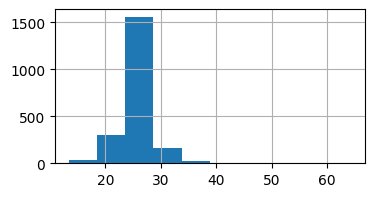

In [ ]:
_ = X["BMI"].hist(figsize=(4,2))

In [ ]:
# Этот код не влияет на работу catboost !
for i in cat_vars:
    classifier = dict()
    cls_num = 0
    if i in X.columns:
        for j in X.index:
            if X[i][j] not in classifier:
                classifier[X[i][j]] = cls_num
                X.loc[j, i]= classifier[X[i][j]]
                cls_num += 1
            else:
                X.loc[j, i]= classifier[X[i][j]]
    else:
        print(i,"not in X")

infarction_stadium2 not in X
baseline_drift not in X
burst_noise not in X
electrodes_problems not in X
extra_beats not in X
pacemaker not in X


In [ ]:
# categorial_data = X[list(set(cat_vars)-set(dropped))]
# numeric_data = X[list(set(X.columns)-set(cat_vars))]
# dummy_features = pd.get_dummies(categorial_data).astype(int)
# # Не помогает!!!
# X = pd.concat([numeric_data, dummy_features], axis=1)
# X.head(3)

In [ ]:
X.head(6)

,age,sex,height,weight,nurse,site,device,scp_codes,heart_axis,infarction_stadium1,second_opinion,validated_by_human,static_noise,strat_fold,group,pred,BMI
0,55.0,0,167.343977,70.000000,2.0,0.0,0,0,0,0,0,1,0,10,1,0,24.996423
1,56.0,0,167.343977,71.605525,2.0,0.0,0,1,0,0,0,1,1,9,3,0,25.569743
2,25.0,1,167.343977,63.000000,2.0,0.0,0,0,0,0,0,1,2,8,3,0,22.496781
3,35.0,0,167.343977,82.000000,2.0,0.0,0,2,0,0,0,1,2,1,2,0,29.281524
4,26.0,0,167.343977,93.000000,2.0,0.0,0,0,0,0,0,1,2,10,3,0,33.209534
5,25.0,0,167.343977,70.000000,2.0,0.0,0,0,0,0,0,1,2,6,1,0,24.996423


In [ ]:
X.isna().sum().sum()

0

In [ ]:
X.drop(["heart_axis", "second_opinion", "height", "weight", "device", "site", "nurse"], axis=1, inplace=True, errors="ignore")

In [ ]:
X.drop(["strat_fold","scp_codes", "static_noise", "sex"], axis=1, inplace=True, errors="ignore")

In [ ]:
'''plt.rcParams['figure.figsize']=(10,10)

corr = X.corr()
g = sns.heatmap(corr, square = True, annot=True)'''
None

In [ ]:
list(dtn['scp_codes'].unique())

["{'NORM': 100.0, 'SR': 0.0}",
 "{'AFLT': 100.0}",
 "{'IRBBB': 100.0, 'SR': 0.0}",
 "{'LVH': 100.0, 'SR': 0.0}",
 "{'NORM': 80.0, 'STACH': 0.0}",
 "{'NDT': 100.0, 'SR': 0.0}",
 "{'ASMI': 50.0, 'ABQRS': 0.0, 'SR': 0.0}",
 "{'NORM': 80.0, 'SR': 0.0}",
 "{'PACE': 100.0}",
 "{'LAFB': 100.0, 'SR': 0.0}",
 "{'NST_': 100.0, 'SR': 0.0}",
 "{'NST_': 100.0, 'PVC': 100.0, 'SR': 0.0}",
 "{'CRBBB': 100.0, 'LAFB': 100.0, 'SR': 0.0}",
 "{'LVH': 100.0, 'ISC_': 100.0, 'SR': 0.0}",
 "{'IMI': 15.0, 'ABQRS': 0.0, 'SR': 0.0}",
 "{'NDT': 100.0, '1AVB': 100.0, 'SR': 0.0}",
 "{'IMI': 100.0, 'CRBBB': 100.0, 'PAC': 0.0, 'LPR': 0.0, 'QWAVE': 0.0, 'SR': 0.0}",
 "{'NORM': 100.0, 'SARRH': 0.0}",
 "{'LVH': 100.0, 'ISC_': 100.0, 'PVC': 100.0, 'NST_': 0.0, 'AFLT': 0.0, 'SVTAC': 0.0}",
 "{'LAFB': 100.0, 'LVOLT': 0.0, 'SR': 0.0}",
 "{'LVH': 100.0, 'ISC_': 100.0}",
 "{'NORM': 80.0, 'PAC': 0.0, 'SR': 0.0}",
 "{'IRBBB': 80.0, 'SR': 0.0}",
 "{'NORM': 80.0, 'IRBBB': 100.0, 'SARRH': 0.0}",
 "{'ASMI': 100.0, 'IMI': 50.0, 'IRBB

In [ ]:
y = ans["myocard"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=45)


In [ ]:
categorical_features_indices = np.where([column_name in cat_vars for column_name in X.columns])[0]
# categorical_features_indices = np.where(X.dtypes != float)[0]

params = {
    'iterations': 100,
    'learning_rate': 0.05,
    'eval_metric': catmetrics.F1(),
    'random_seed': 50,
    'logging_level': 'Silent',
    'use_best_model': True
}
train_pool = Pool(X_train, y_train, cat_features=categorical_features_indices)
validate_pool = Pool(X_test, y_test, cat_features=categorical_features_indices)
best_model = CatBoostClassifier(**params)
best_model.fit(train_pool, eval_set=validate_pool)

    
print(f1_score(y_test, best_model.predict(X_test), average = 'macro'))
print(f1_score(y_test, best_model.predict(X_test)))
print(accuracy_score(y_test, best_model.predict(X_test)))

0.8697154013666741
0.7826086956521738
0.9279538904899135


In [ ]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
sc = StandardScaler()

In [ ]:
def fit_and_print_f1(model, scale=True, name=None):
    if name is None:
        name = model.__class__.__name__[:10]+"."
    if scale:
        model.fit(pd.DataFrame(sc.fit_transform(X_train)),y_train)
    print(name+": ",f1_score(y_test, np.array(model.predict( pd.DataFrame(sc.transform(X_test))) > 0.5), average = 'macro'))
    return model

In [ ]:
elastic = fit_and_print_f1(ElasticNet(alpha=0.4, max_iter=20000))
linear = fit_and_print_f1(LinearRegression())
knn = fit_and_print_f1(KNeighborsRegressor(15))
forest = fit_and_print_f1(RandomForestRegressor(200, max_depth=5))
tree = fit_and_print_f1(DecisionTreeClassifier(max_depth=5))

ElasticNet.:  0.4578125
LinearRegr.:  0.8448622736643402
KNeighbors.:  0.8567197756040608
RandomFore.:  0.8639808362369339
DecisionTr.:  0.871958962040611


In [ ]:
print({X.columns[i]:w for i,w in enumerate(list(np.around(linear.coef_ * 1e02, decimals=4)))})

{'age': 2.2549, 'infarction_stadium1': 16.6038, 'validated_by_human': -1.9907, 'group': -0.0149, 'pred': 19.7492, 'BMI': -0.8895}


In [ ]:
X.head()

,age,infarction_stadium1,validated_by_human,group,pred,BMI
0,55.0,0,1,1,0,24.996423
1,56.0,0,1,3,0,25.569743
2,25.0,0,1,3,0,22.496781
3,35.0,0,1,2,0,29.281524
4,26.0,0,1,3,0,33.209534


In [ ]:
X["group"].unique()

array([1, 3, 2], dtype=int64)

In [ ]:
def test_random(X,y,scale=False,n=100):
    m=[]
    for i in range(0,n):
        X_tn, X_tt, y_tn, y_tt = train_test_split(X, y, test_size=0.33, random_state=i)
        if scale:
            sc = StandardScaler()

            X_tn = pd.DataFrame(sc.fit_transform(X_tn))
            X_tt = pd.DataFrame(sc.transform(X_tt))
        params = {
            'iterations': 150,
            'learning_rate': 0.05,
            'eval_metric': catmetrics.F1(),
            'random_seed': 50,
            'logging_level': 'Silent',
            'use_best_model': True
        }
        train_pool = Pool(X_tn, y_tn, cat_features=[])
        validate_pool = Pool(X_tt, y_tt, cat_features=[])
        best_model = CatBoostClassifier(**params)
        best_model.fit(train_pool, eval_set=validate_pool)
        pp = best_model.predict(X_tt)
        m.append(f1_score(y_tt, pp, average = 'macro'))
    print("RESULT:",np.array(m).mean()*100)


In [ ]:
X_tn, X_tt, y_tn, y_tt = train_test_split(X, y, test_size=0.33, random_state=i)
        if scale:
            sc = StandardScaler()

            X_tn = pd.DataFrame(sc.fit_transform(X_tn))
            X_tt = pd.DataFrame(sc.transform(X_tt))
        params = {
            'iterations': 150,
            'learning_rate': 0.05,
            'eval_metric': catmetrics.F1(),
            'random_seed': 50,
            'logging_level': 'Silent',
            'use_best_model': True
        }
        train_pool = Pool(X_tn, y_tn, cat_features=[])
        validate_pool = Pool(X_tt, y_tt, cat_features=[])
        best_model = CatBoostClassifier(**params)
        best_model.fit(train_pool, eval_set=validate_pool)
        pp = best_model.predict(X_tt)

In [ ]:
test_random(X,y)

RESULT: 88.22174505191275


In [ ]:
test_random(X,y,True)

RESULT: 88.18394021664268


In [ ]:
#raise Exception("booba")

Exception: booba

In [ ]:
y = ans["myocard"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=23)


In [ ]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense
# Задаем сеть 
model = Sequential()
model.add(Dense(round(X.shape[1] / 1.2), input_shape=(X.shape[1],)))
model.add(Dense(round(X.shape[1] / 2), activation='relu'))
model.add(Dense(round(X.shape[1] / 3.6), activation='relu'))
model.add(Dense(round(X.shape[1] / 5)))
model.add(Dense(round(X.shape[1] / 7), activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.compile(optimizer='SGD', loss='binary_crossentropy',  metrics=["Recall"])

In [ ]:
#history = model.fit(X_train, y_train, batch_size=25, epochs=200, validation_split=0.2, verbose=0)

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type float).

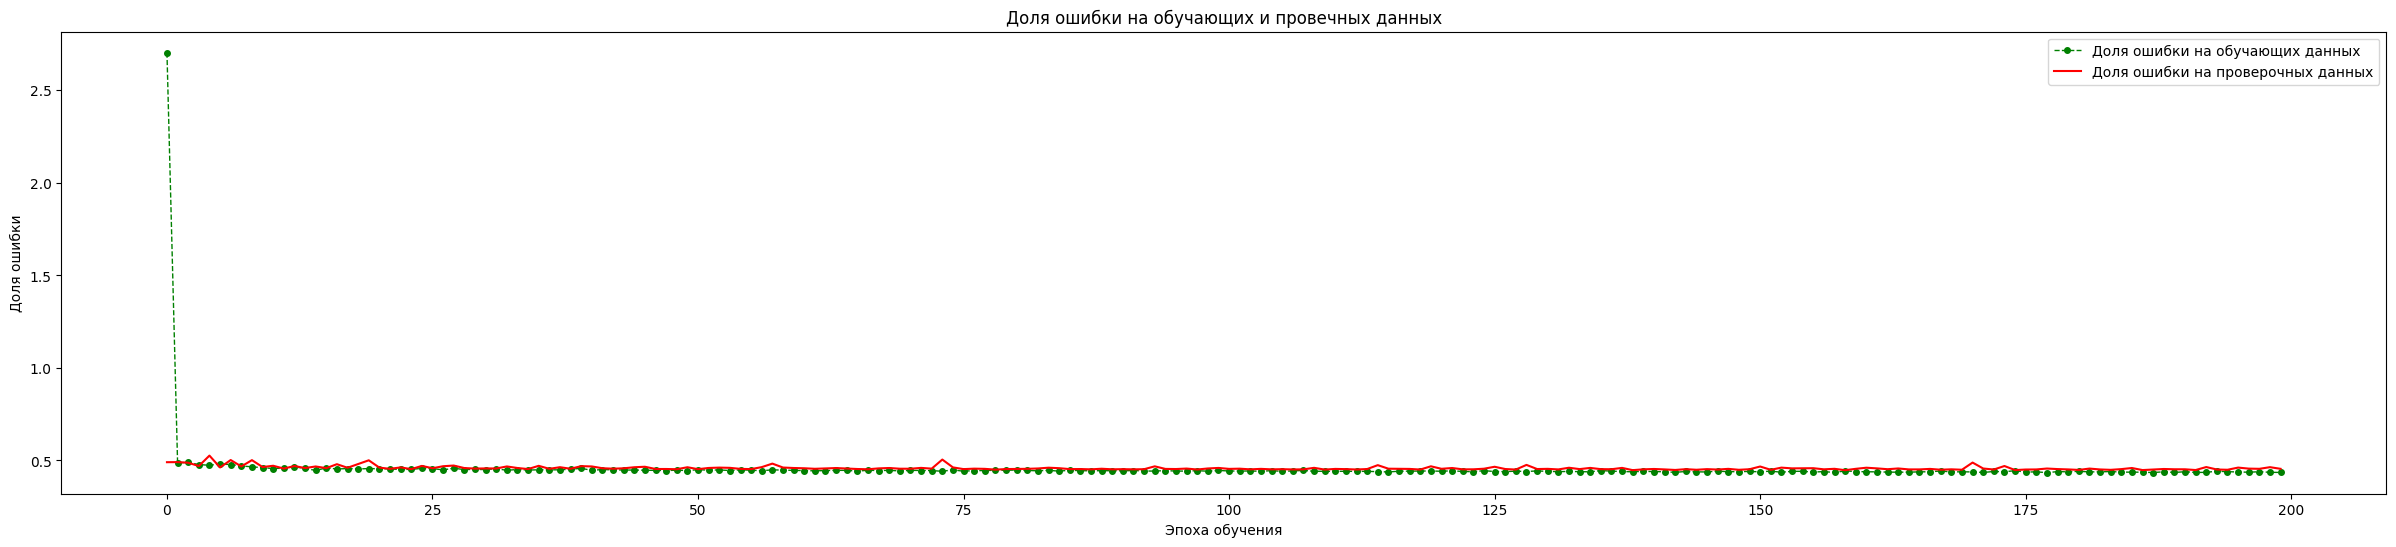

In [ ]:
plt.figure(figsize=(30, 6))
plt.title('Доля ошибки на обучающих и провечных данных')
plt.plot(history.history['loss'][0:], 'go', linewidth=1, markersize=4, linestyle='--',
         label='Доля ошибки на обучающих данных')
plt.plot(history.history['val_loss'][0:], 'r', linewidth=1.5, markersize=1, linestyle='-',
         label='Доля ошибки на проверочных данных')

plt.xlabel('Эпоха обучения')
plt.ylabel('Доля ошибки'),
plt.legend()
plt.show()

In [ ]:
print(f1_score(y_test, np.array(model.predict(X_test) > 0.5), average = 'macro'))
print(f1_score(y_test, np.array(model.predict(X_test) > 0.5)))

0.4386712095400341
0.0


In [ ]:
params = {
    'iterations': 100,
    'learning_rate': 0.05,
    'eval_metric': catmetrics.F1(),
    'random_seed': 50,
    'logging_level': 'Silent',
    'use_best_model': True
}
train_pool = Pool(X_train, y_train, cat_features=[])
validate_pool = Pool(X_test, y_test, cat_features=[])
best_model = CatBoostClassifier(**params)
best_model.fit(train_pool, eval_set=validate_pool)

    
print(f1_score(y_test, best_model.predict(X_test), average = 'macro'))
print(f1_score(y_test, best_model.predict(X_test)))

0.8456458883490432
0.7560137457044674


In [ ]:
X_train_stack = np.hstack((X_train, np.array(best_model.predict(X_train) > 0.5).reshape(-1,1))) 
X_test_stack = np.hstack((X_test, np.array(best_model.predict(X_test) > 0.5).reshape(-1,1)))

In [ ]:
def fit_and_print_f1_stacked(model, name=None):
    if name is None:
        name = model.__class__.__name__[:10]+"."
    model.fit(X_train_stack,y_train)
    print(name+": ",f1_score(y_test, np.array(model.predict(X_test_stack) > 0.5), average = 'macro'))
    return model

In [ ]:
from sklearn.svm import LinearSVC

elastic = fit_and_print_f1_stacked(ElasticNet(alpha=0.4, max_iter=20000))
linear = fit_and_print_f1_stacked(LinearRegression())
knn = fit_and_print_f1_stacked(KNeighborsRegressor(15))
forest = fit_and_print_f1_stacked(RandomForestRegressor(200, max_depth=3))
svc = fit_and_print_f1_stacked(LinearSVC(
						   C = 3, 
						   intercept_scaling = 0.4, 
						   class_weight = 'balanced', 
						   random_state = 1057832
						 ))

ElasticNet.:  0.4386712095400341


LinearRegr.:  0.8341303800654417
KNeighbors.:  0.48465570444265965
RandomFore.:  0.8240271607763987
LinearSVC.:  0.7206873964474242


c:\Users\MoreIT\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [ ]:
print(dict(enumerate(list(np.around(linear.coef_ * 1e02, decimals=4)))))

{0: 1.8635, 1: 0.1264, 2: -0.0447, 3: 0.2638, 4: 1.0769, 5: 0.0599, 6: 10.1961, 7: 4.4043, 8: -1.5997, 9: -16.2333, 10: 0.0627, 11: -5.7837, 12: -6.4751, 13: -2.9628, 14: -13.7663, 15: -4.5103, 16: -11.2345, 17: 39.455, 18: 3.3435, 19: 5.0822, 20: -4.6377, 21: -9.1839, 22: 4.8899, 23: 4.3043, 24: 0.0, 25: 0.0, 26: -0.5816, 27: 0.0, 28: 0.0, 29: -54.9685, 30: 0.0, 31: -13.7197, 32: 96.6932, 33: -4.8935, 34: 7.3142, 35: -3.0199, 36: -43.9392, 37: -11.5972, 38: 9.0325, 39: -4.8133, 40: 7.0712, 41: -1.2724, 42: 12.1276, 43: 0.0, 44: 0.0, 45: 29.5714, 46: 3.3095, 47: 11.2789, 48: -2.0462, 49: 19.7348, 50: -29.2285, 51: -30.3576, 52: -0.0, 53: -3.3803, 54: -5.6336, 55: -10.1298, 56: 9.937, 57: -7.8292, 58: -14.5663, 59: -0.0, 60: -0.3212, 61: -17.898, 62: 0.9948, 63: 1.6796, 64: -0.0, 65: -0.5831, 66: -2.7808, 67: -0.0, 68: -6.2126, 69: 8.0881, 70: -0.0, 71: -4.2099, 72: 1.4318, 73: -8.8516, 74: 5.3921, 75: 0.1795, 76: -0.0, 77: -0.0, 78: -6.8744, 79: -2.1329, 80: 0.0, 81: 42.6869, 82: 0.0, 

In [ ]:
X_train_stack = np.hstack((X_train_stack, np.array(forest.predict(X_train_stack) > 0.5).reshape(-1,1))) 
X_test_stack = np.hstack((X_test_stack, np.array(forest.predict(X_test_stack) > 0.5).reshape(-1,1))) 

In [ ]:
finaler = Sequential()
finaler.add(Dense(44, input_shape=(X_train_stack.shape[1],)))
finaler.add(Dense(11, activation='relu'))
finaler.add(Dense(6, activation='relu'))
finaler.add(Dense(1, activation='sigmoid'))
finaler.compile(optimizer='SGD', loss='binary_crossentropy',  metrics=["Accuracy"])

In [ ]:
history = finaler.fit(X_train_stack, y_train, batch_size=20, epochs=100, validation_split=0.2, verbose=0)

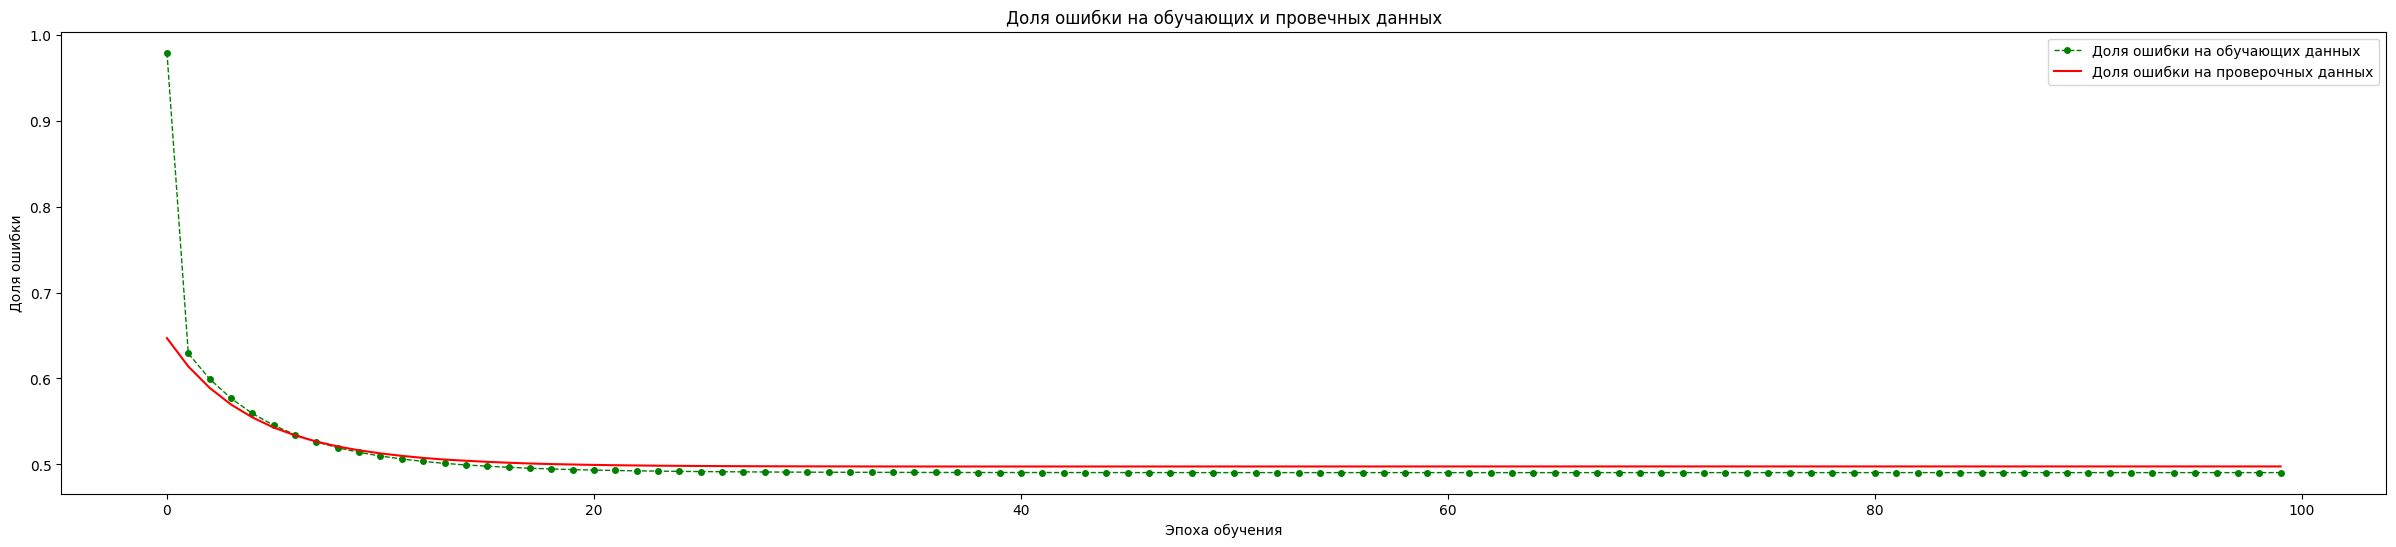

In [ ]:
plt.figure(figsize=(30, 6))
plt.title('Доля ошибки на обучающих и провечных данных')
plt.plot(history.history['loss'][0:], 'go', linewidth=1, markersize=4, linestyle='--',
         label='Доля ошибки на обучающих данных')
plt.plot(history.history['val_loss'][0:], 'r', linewidth=1.5, markersize=1, linestyle='-',
         label='Доля ошибки на проверочных данных')

plt.xlabel('Эпоха обучения')
plt.ylabel('Доля ошибки'),
plt.legend()
plt.show()

In [ ]:
print(f1_score(y_test, np.array(finaler.predict(X_test_stack) > 0.5), average = 'macro'))
print(f1_score(y_test, np.array(finaler.predict(X_test_stack) > 0.5)))

0.4386712095400341
0.0


In [ ]:
df_y = pd.read_csv('train/train_gts.csv', index_col=0)
